# Exercise 2: Normalizing Flow
Exercise by [Jes Frellsen](https://frellsen.org) (Technical University of Denmark), June 2024 (version 1.0).

The main task in this programming exercise, is to implement the *masked coupling layer* from Real NVP ([Dinh et al., 2017](https://arxiv.org/abs/1605.08803)) on two simple 2D toy datasets. We have provided you with a file for the toy data:
* `ToyData.py` contains the code for generating data from the two toy models.

The code is followed by one exercise you have to solve.

This implementation in the notebook takes inspiration from:
* https://github.com/jmtomczak/intro_dgm/blob/main/flows/realnvp_example.ipynb
* https://github.com/VincentStimper/normalizing-flows/tree/master

### Masked coupling layer

The advantage of using the masked coupling layer ([Dinh et al., 2017](https://arxiv.org/abs/1605.08803)) over a regular coupling layer, is that it allows for arbitrary partitioning of the variable in the coupling layer. Let $T: \mathbb{R}^D \to \mathbb{R}^D$ be the masked coupling transformation that maps $\mathbf{z}$ to $\mathbf{z}'$. Then let $\mathbf{b} \in \{0,1\}^D$ denote a binary mask, where $b_i = 1$ means that $z_i$ is left unchanged by the coupling layer and $b_i = 0$ means that $z_i$ is transformed by the coupling layer. We can then express the masked coupling layer as the transformation
$$
    \mathbf{z}' = \mathbf{b} \odot \mathbf{z} + (\mathbf{1}-\mathbf{b}) \odot \left( \mathbf{z} \odot \exp\left(s(\mathbf{b} \odot \mathbf{z})\right) + t(\mathbf{b} \odot \mathbf{z}) \right)
$$
where $\odot$ is the element wise product, $s:\mathbb{R}^D \to \mathbb{R}^D$ is the network that calculates the scaling and $t:\mathbb{R}^D \to \mathbb{R}^D$ is the network that calculates translation of the affine transformation. Note that the input to these networks are masked by multiplying $\mathbf{z}$ by the mask, and that $\mathbf{b} \odot \mathbf{z} = \mathbf{b} \odot \mathbf{z}'$.

The inverse of the transformation is given by an expression similar to the inverse of the regular couple layers, i.e.,
$$
    \mathbf{z} = \mathbf{b} \odot \mathbf{z}' + (\mathbf{1}-\mathbf{b}) \odot
    \left( \left(\mathbf{z}' - t(\mathbf{b} \odot \mathbf{z}')\right)  \odot \exp\left(-s(\mathbf{b} \odot \mathbf{z}')\right) \right) ,
$$
and the log determinant of the Jacobian is given by
\begin{equation}
    \log \left\vert \det \mathbf{J}_T (z) \right\vert = \sum_{d=1}^{D} (1-b_i) s_i(\mathbf{b} \odot \mathbf{z}) .
\end{equation}

You can download `ToyData.py` using the following commands:

In [1]:
! curl -O https://raw.githubusercontent.com/frellsen/ProbAI-2024/main/ToyData.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3653  100  3653    0     0  52233      0 --:--:-- --:--:-- --:--:-- 55348


## Toy data
First we visualize the probability densities for the toy datasets.

When we create an object of the `Chequerboard` or `TwoGaussian`, we can call the forward method which returns a `Distribution` object from `torch.distributions`. The `Distribution` class implements a method for calculating the log probability (`log_prob(...)`), which we will use to make the plots below, and a method for sampling from the distribution (`sample(...)`), which we will later use for creating our training data.

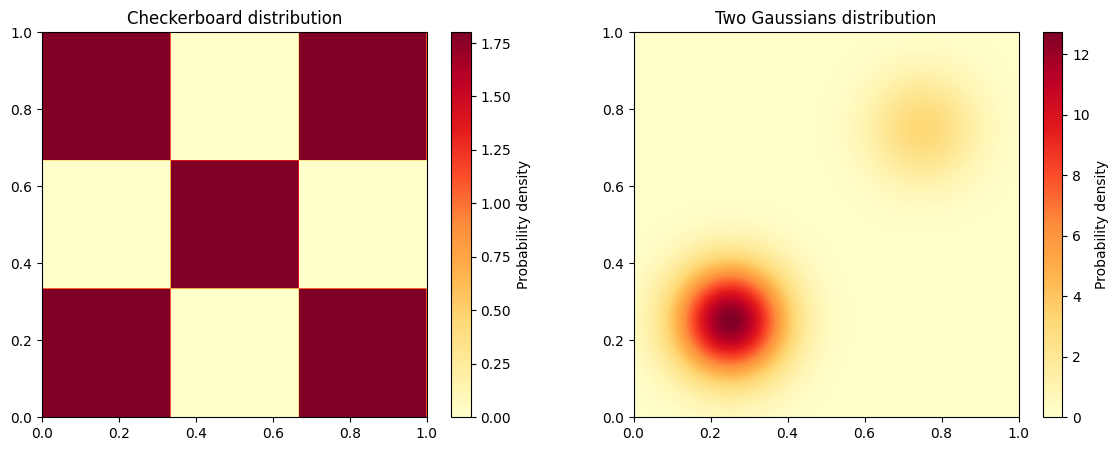

In [2]:
import torch
import ToyData
import matplotlib.pyplot as plt
import numpy as np

# Make a density plot of the Checkerboard distribution
toy = ToyData.Chequerboard()
coordinates = [[[x,y] for x in np.linspace(*toy.xlim, 1000)] for y in np.linspace(*toy.ylim, 1000)]
prob = torch.exp(toy().log_prob(torch.tensor(coordinates)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
im = ax1.imshow(prob, extent=[toy.xlim[0], toy.xlim[1], toy.ylim[0], toy.ylim[1]], origin='lower', cmap='YlOrRd')
ax1.set_xlim(toy.xlim)
ax1.set_ylim(toy.ylim)
ax1.set_aspect('equal')
cbar1 = fig.colorbar(im, ax=ax1)
ax1.set_title('Checkerboard distribution')
cbar1.set_label('Probability density')

# Make a density plot of the Gaussian distribution
toy = ToyData.TwoGaussians()
coordinates = [[[x,y] for x in np.linspace(*toy.xlim, 1000)] for y in np.linspace(*toy.ylim, 1000)]
prob = torch.exp(toy().log_prob(torch.tensor(coordinates)))

im = ax2.imshow(prob, extent=[toy.xlim[0], toy.xlim[1], toy.ylim[0], toy.ylim[1]], origin='lower', cmap='YlOrRd')
ax2.set_xlim(toy.xlim)
ax2.set_ylim(toy.ylim)
ax2.set_aspect('equal')
ax2.set_title('Two Gaussians distribution')
cbar2 = fig.colorbar(im, ax=ax2)
cbar2.set_label('Probability density')

## Implementing a Normalizing Flow
**Flow implementation:** Below we provide an implementation of a flow (`Flow`) and a masked coupling layer (`MaskedCouplingLayer`). The masked coupling layer is missing the implementaion of the `forward`and `inverse` methods. Your task will be to complete them (see the exercise below).

In [3]:
import torch
import torch.nn as nn
import torch.distributions as td

class GaussianBase(nn.Module):
    def __init__(self, D):
        """
        Define a Gaussian base distribution with zero mean and unit variance.

                Parameters:
        M: [int] 
           Dimension of the base distribution.
        """
        super(GaussianBase, self).__init__()
        self.D = D
        self.mean = nn.Parameter(torch.zeros(self.D), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.D), requires_grad=False)

    def forward(self):
        """
        Return the base distribution.

        Returns:
        prior: [torch.distributions.Distribution]
        """
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)

class MaskedCouplingLayer(nn.Module):
    """
    An affine coupling layer for a normalizing flow.
    """

    def __init__(self, scale_net, translation_net, mask):
        """
        Define a coupling layer.

        Parameters:
        scale_net: [torch.nn.Module]
            The scaling network that takes as input a tensor of dimension `(batch_size, feature_dim)` and outputs a tensor of dimension `(batch_size, feature_dim)`.
        translation_net: [torch.nn.Module]
            The translation network that takes as input a tensor of dimension `(batch_size, feature_dim)` and outputs a tensor of dimension `(batch_size, feature_dim)`.
        mask: [torch.Tensor]
            A binary mask of dimension `(feature_dim,)` that determines which features (where the mask is zero) are transformed by the scaling and translation networks.
        """
        super(MaskedCouplingLayer, self).__init__()
        self.scale_net = scale_net
        self.translation_net = translation_net
        self.mask = nn.Parameter(mask, requires_grad=False)

    def forward(self, z):
        """
        Transform a batch of data through the coupling layer (from the base to data).

        Parameters:
        x: [torch.Tensor]
            The input to the transformation of dimension `(batch_size, feature_dim)`
        Returns:
        z: [torch.Tensor]
            The output of the transformation of dimension `(batch_size, feature_dim)`
        sum_log_det_J: [torch.Tensor]
            The sum of the log determinants of the Jacobian matrices of the forward transformations of dimension `(batch_size, feature_dim)`.
        """
        x = z
        log_det_J = torch.zeros(z.shape[0])
        return x, log_det_J
    
    def inverse(self, x):
        """
        Transform a batch of data through the coupling layer (from data to the base).

        Parameters:
        z: [torch.Tensor]
            The input to the inverse transformation of dimension `(batch_size, feature_dim)`
        Returns:
        x: [torch.Tensor]
            The output of the inverse transformation of dimension `(batch_size, feature_dim)`
        sum_log_det_J: [torch.Tensor]
            The sum of the log determinants of the Jacobian matrices of the inverse transformations.
        """
        z = x
        log_det_J = torch.zeros(x.shape[0])
        return z, log_det_J


class Flow(nn.Module):
    def __init__(self, base, transformations):
        """
        Define a normalizing flow model.
        
        Parameters:
        base: [torch.distributions.Distribution]
            The base distribution.
        transformations: [list of torch.nn.Module]
            A list of transformations to apply to the base distribution.
        """
        super(Flow, self).__init__()
        self.base = base
        self.transformations = nn.ModuleList(transformations)

    def forward(self, z):
        """
        Transform a batch of data through the flow (from the base to data).
        
        Parameters:
        x: [torch.Tensor]
            The input to the transformation of dimension `(batch_size, feature_dim)`
        Returns:
        z: [torch.Tensor]
            The output of the transformation of dimension `(batch_size, feature_dim)`
        sum_log_det_J: [torch.Tensor]
            The sum of the log determinants of the Jacobian matrices of the forward transformations.            
        """
        sum_log_det_J = 0
        for T in self.transformations:
            x, log_det_J = T(z)
            sum_log_det_J += log_det_J
            z = x
        return x, sum_log_det_J
    
    def inverse(self, x):
        """
        Transform a batch of data through the flow (from data to the base).

        Parameters:
        x: [torch.Tensor]
            The input to the inverse transformation of dimension `(batch_size, feature_dim)`
        Returns:
        z: [torch.Tensor]
            The output of the inverse transformation of dimension `(batch_size, feature_dim)`
        sum_log_det_J: [torch.Tensor]
            The sum of the log determinants of the Jacobian matrices of the inverse transformations.
        """
        sum_log_det_J = 0
        for T in reversed(self.transformations):
            z, log_det_J = T.inverse(x)
            sum_log_det_J += log_det_J
            x = z
        return z, sum_log_det_J
    
    def log_prob(self, x):
        """
        Compute the log probability of a batch of data under the flow.

        Parameters:
        x: [torch.Tensor]
            The data of dimension `(batch_size, feature_dim)`
        Returns:
        log_prob: [torch.Tensor]
            The log probability of the data under the flow.
        """
        z, log_det_J = self.inverse(x)
        return self.base().log_prob(z) + log_det_J
    
    def sample(self, sample_shape=(1,)):
        """
        Sample from the flow.

        Parameters:
        n_samples: [int]
            Number of samples to generate.
        Returns:
        z: [torch.Tensor]
            The samples of dimension `(n_samples, feature_dim)`
        """
        z = self.base().sample(sample_shape)
        return self.forward(z)[0]
    
    def loss(self, x):
        """
        Compute the negative mean log likelihood for the given data bath.

        Parameters:
        x: [torch.Tensor] 
            A tensor of dimension `(batch_size, feature_dim)`
        Returns:
        loss: [torch.Tensor]
            The negative mean log likelihood for the given data batch.
        """
        return -torch.mean(self.log_prob(x))

**Training loop**: We have also implemented a generic training loop for learning the DDPM model.

In [4]:
from tqdm.notebook import tqdm

def train(model, optimizer, data_loader, epochs, device):
    """
    Train a Flow model.

    Parameters:
    model: [Flow]
       The model to train.
    optimizer: [torch.optim.Optimizer]
         The optimizer to use for training.
    data_loader: [torch.utils.data.DataLoader]
            The data loader to use for training.
    epochs: [int]
        Number of epochs to train for.
    device: [torch.device]
        The device to use for training.
    """
    model.train()

    total_steps = len(data_loader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        data_iter = iter(data_loader)
        for x in data_iter:
            if isinstance(x, (list, tuple)):
                x = x[0]
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()


**Training data**: Next, we generate some training data from the TwoGaussians datasets and create a `data_loader`. We generate a dataset with 10M data points and use a large batch size of 10,000. We can do so, since it is only a two-dimensional dataset.

In [5]:
# Generate the data
import ToyData

batch_size = 10000
n_data = 10000000

toy = ToyData.TwoGaussians()
train_loader = torch.utils.data.DataLoader(toy().sample((n_data,)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(toy().sample((n_data,)), batch_size=batch_size, shuffle=True)

**Initialize the model and run the training loop**: Finally we initialize the model using a simple fully connected encoder and decoder networks and run the training loop. *Remember that this will not work before you have completed the assignment below.*

Here we define 10 transformations consisting of masked coupling layers, where we alternative between masking the first and second part of the input, and both the scale and translation nets have one hidden layer with 16 units.

In [6]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get the dimension of the dataset
D = next(iter(train_loader)).shape[1]

# Define prior distribution
base = GaussianBase(D)

# Define the transformations
transformations =[]

num_transformations = 5
num_hidden = 8

# Make a mask that is 1 for the first half of the features and 0 for the second half
mask = torch.zeros((D,))
mask[D//2:] = 1

for i in range(num_transformations):
    mask = (1-mask) # Flip the mask
    scale_net = nn.Sequential(nn.Linear(D, num_hidden), nn.ReLU(), nn.Linear(num_hidden, D))
    translation_net = nn.Sequential(nn.Linear(D, num_hidden), nn.ReLU(), nn.Linear(num_hidden, D))
    transformations.append(MaskedCouplingLayer(scale_net, translation_net, mask))

# Define flow model
model = Flow(base, transformations).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters())

# Train model
epochs = 1
train(model, optimizer, train_loader, epochs, device)


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

**Sampling**: The following code samples from a trained model and plots the samples

In [ ]:
model.eval()
with torch.no_grad():
    samples = (model.sample((10000,))).cpu() 

# Plot the density of the toy data and the model samples
coordinates = [[[x,y] for x in np.linspace(*toy.xlim, 1000)] for y in np.linspace(*toy.ylim, 1000)]
prob = torch.exp(toy().log_prob(torch.tensor(coordinates)))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(prob, extent=[toy.xlim[0], toy.xlim[1], toy.ylim[0], toy.ylim[1]], origin='lower', cmap='YlOrRd')
ax.scatter(samples[:, 0], samples[:, 1], s=1, c='black', alpha=0.5)
ax.set_xlim(toy.xlim)
ax.set_ylim(toy.ylim)
ax.set_aspect('equal')
fig.colorbar(im)

## Exercises

### Exercise 1.1

In the provided code, the class `MaskedCouplingLayer` implements the masked coupling layer from Real NVP ([Dinh et al., 2017](https://arxiv.org/abs/1605.08803)), but it does not implement the forward transformation, the inverse transformation and the corresponding calculations of the log determinant of the Jacobian. 
    
In this exercise you should complete the following two functions such that:
* `MaskedCouplingLayer.forward(...)` returns $T(\mathbf{z})$ and $\log \left\vert\det \mathbf{J}_T (\mathbf{z})\right\vert$.
* `MaskedCouplingLayer.inverse(...)` returns $T^{-1}(\mathbf{z}')$ and $\log \left\vert\det \mathbf{J}_{T^{-1}} (\mathbf{z}')\right\vert$.

Use the TwoGaussians datasets for testing the model. Adjust the number of coupling layers and the architecture of the networks to get a good fit to the density (by qualitative assessment). Make sure to write your implementation such that it works on data of more than two dimensions.

**Optional:** Can you also fit a flow to the Chequerboard dataset? It is difficult to find an architecture that gives a good fit.
